# CASE STUDY
# K-Mean Clustering

**Overview**<br>
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

We discuss the online reatil trasnational dataset to build a RFM clustering and choose the best set of customers. RFM clustering is a method employed in marketing and customer segmentation to group customers based on their recentness, frequency, and monetary value of their interactions or transactions with a business. The acronym RFM stands for:

<b>Recency (R)</b>: This represents how recently a customer has interacted with the business or made a purchase. Customers who have interacted or made purchases more recently are typically considered more engaged or valuable.

<b>Frequency (F)</b>: Frequency refers to how often a customer interacts with the business or makes purchases. Customers who interact frequently are often considered more loyal.

<b>Monetary Value (M)</b>: This represents the amount of money a customer has spent or the value of their transactions. Customers who have spent more are often considered more valuable to the business.

<b>RFM</b> clustering involves assigning each customer a score for each of these three dimensions (Recency, Frequency, Monetary Value). The scores are typically based on quantiles or percentiles, and then customers are grouped into segments or clusters based on their RFM scores. Common methods for scoring include:

In [1]:
#Importing Libraries
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Let's look at KMeans package help to better understand the KMeans implementation in Python using SKLearn

### Reading the Data Set

In [2]:
#reading Dataset
retail = pd.read_csv("Online_Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)

# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

### Data quality check and cleaning

In [3]:
# Let's look top 5 rows
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#Sanity Check
retail.shape
retail.describe()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Na Handling
retail.isnull().values.sum()

136534

In [6]:
# dropping the na cells
order_wise = retail.dropna()

In [7]:
# Sanity check
order_wise.shape
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Extracting R(Recency), F(Frequency), M(Monetary) columns form the data that we imported in.

In [8]:
# RFM implementation

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


#### Monetary Value

In [9]:
# merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

# Monetary Function
# Finding total amount spent per customer
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### If in the above result you get a column with name level_1, uncomment the below code and run it, else ignore it and keeping moving.

In [10]:
# monetary.drop(['level_1'], axis = 1, inplace = True)
# monetary.head()

#### Frequency Value

In [11]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [12]:
# Getting the count of orders made by each customer based on customer ID.
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


##### Merging Amount and Frequency columns

In [13]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Recency Value

In [14]:
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)

In [15]:
#Generating recency function

# Filtering data for customerid and invoice_date
recency  = order_wise[['CustomerID','InvoiceDate']]

# Finding max data
maximum = max(recency.InvoiceDate)

# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [16]:
# recency by customerid
a = recency.groupby('CustomerID')

In [17]:
import pandas as pd

# Calculate the minimum 'diff' for each 'CustomerID' group
a = recency.groupby('CustomerID')['diff'].min().reset_index()

# Create a DataFrame for recency by customer
df = pd.DataFrame(a)
df.columns = ["CustomerID", "Recency"]
df.head()


,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


### RFM combined DataFrame

In [18]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


### Outlier Treatment
Outliers are data points that significantly differ from the majority of the data in a dataset. They may have values that are abnormally high or low, which might distort machine learning models and statistical analysis. For data analysis and modelling to be accurate and representational of the underlying patterns in the data, outliers must be recognised and dealt with appropriately.

* <b>IQR (Interquartile Range)</b>: Calculate the IQR for a variable and identify data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR as outliers.
* <b>Z-Score</b>: Calculate the Z-Score for each data point and identify data points with Z-Scores beyond a certain threshold (e.g., ±3 standard deviations) as outliers.

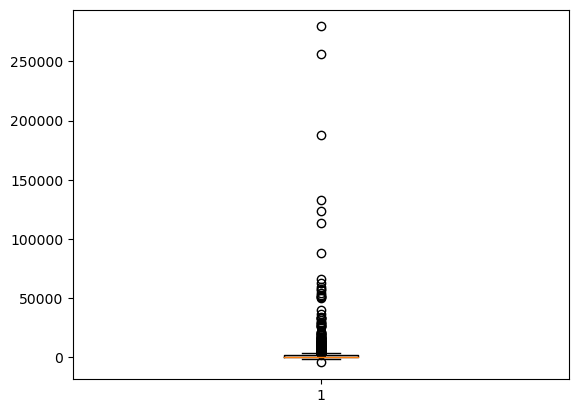

In [19]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

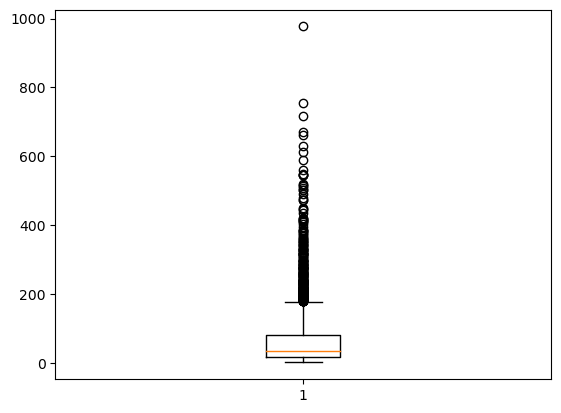

In [20]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

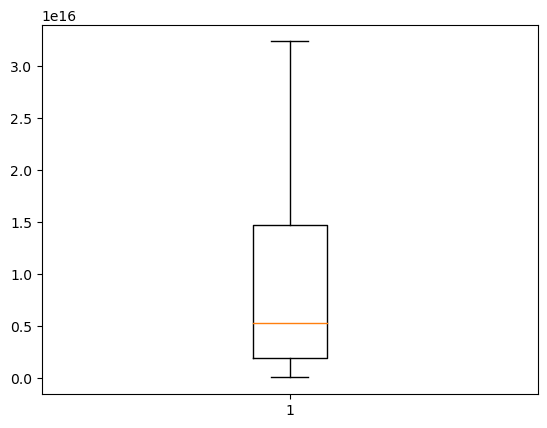

In [21]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [22]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
6,12353.0,4,89.00,204 days 19:03:00
7,12354.0,58,1079.40,232 days 23:39:00
8,12355.0,13,459.40,214 days 23:01:00
9,12356.0,59,2811.43,23 days 04:10:00
11,12358.0,19,1168.06,2 days 02:24:00


### Scaling the RFM data

In [23]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [24]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-1.070949,-1.041614,2.136422
1,-0.375498,1.385298,-0.282050
2,0.631707,1.331702,-0.821629
3,-0.711233,-0.590055,1.982257
4,1.159290,1.045238,-0.657828


## K-Means with some K

In [25]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5)

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [26]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

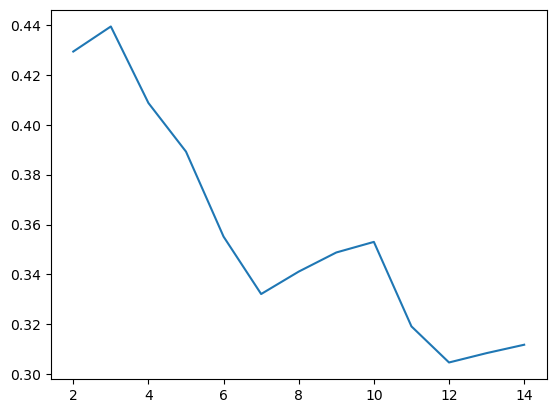

In [27]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

## Sum of Squared Distances

In [ ]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [ ]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [ ]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


In [ ]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

### Reference
* <big>Machine Learning with Real World Projects, Geekshub Pvt. Ltd., Packt publishing, 2019.</big>